# PRACTICA GUIADA 2: Componentes principales para reconocimiento facial

Utilizamos componentes principales para reducir la dimensionalidad de las imágenes. 

In [2]:
!pip install joblib

    100% |████████████████████████████████| 184kB 1.7MB/s ta 0:00:01


In [3]:
#Importamos el dataset lfw desde nuestro sistema de archivos para evitar tener que descargarlo de internet.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import joblib
faces = joblib.load("./../Data/faces.dump")
faces.target_names
faces.data.shape

(1348, 2914)

En el dataset tenemos 1348 imágenes representadas por 2914 píxels cada una en una escala de grises.

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=150, svd_solver='randomized')
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

En el paso anterior corrimos RadomizedPCA para encontrar los 150 primeros componentes principales.

La razón de utilizarRandomizedPCA es que la matriz tiene una dimensión muy grande. RandomizedPCA hace una búsqueda eficiente de los componentes principales que garantiza una solución parecida a la óptima en un tiempo menor.

#### Visualización de los componentes principales

In [7]:
pca.components_[0].shape

(2914,)

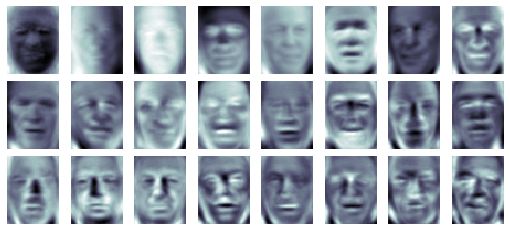

In [8]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')


En la imagen de arriba podemos ver una representación de 24 de los componentes principales. 
Estas imágenes son interesantes porque representan las características distintivas de una cara.
Las de la esquina superior izquierda parecen estar relacionadas con la forma de la cara y las de la línea inferior parecen relacionadas con la forma de algunos razgos de la cara.

#### Variabilidad explicada

Dibujamos la curva de varianza explicada:

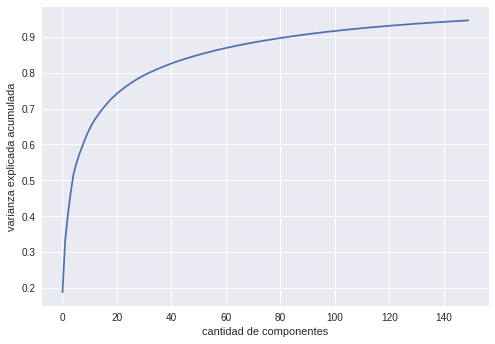

In [9]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('cantidad de componentes')
plt.ylabel('varianza explicada acumulada');


Aquí se ve que los componentes calculados dan cuenta de más del 90% de la varianza original, con lo cual son una buena aproximación a ese conjunto de datos.
Ahora usamos el modelo para reconstruir los datos a partir de los registros comprimidos:

In [10]:
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

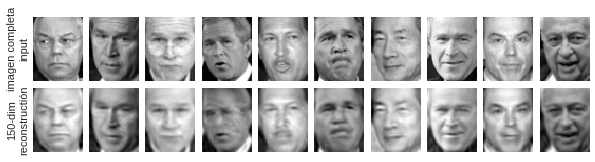

In [11]:
# Imprimimos los resultados
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('imagen completa\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstructión');

## Feature engineering

Ya que vemos que los 150 primeros componentes son una representación aceptable del dataset, podemos utilizarlos en un modelo predictivo en lugar de los datos originales.
Reducir la dimensión permite que los algoritmos de clasificación trabajen mejor y en menos tiempo.

In [12]:
from sklearn.svm import SVC
from sklearn.decomposition import RandomizedPCA
from sklearn.pipeline import make_pipeline

# Armamos un pipeline para aplicar en orden los 
pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Hacemos un split entre train y test tradicional sobre los píxels contenidos en faces.data

In [13]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

In [14]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 54.6 s, sys: 20 ms, total: 54.6 s
Wall time: 54.7 s
{'svc__C': 5, 'svc__gamma': 0.005}


Una vez elegidos los mejores parámetros, armamos el fit con el mejor modelo:

In [15]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Con los valores ajustados, armamos una visualización de los rostros bien y mal clasificados. Se marca en rojo los que tuvieron error de predicción.

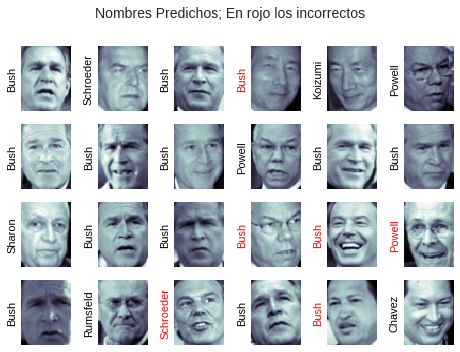

In [16]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Nombres Predichos; En rojo los incorrectos', size=14);

Algunas métricas de la clasificación:

In [17]:
# precision =  verdaderos positivos / casos
# recall = verdaderos positivos / verdaderos positivos + falsos positivos
# f1-score = 2 * (precision * recall) / (precision + recall)
# support = la cantidad de veces que aparece la clase en test

from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))


                   precision    recall  f1-score   support

     Ariel Sharon       0.92      0.80      0.86        15
     Colin Powell       0.80      0.94      0.86        68
  Donald Rumsfeld       0.88      0.68      0.76        31
    George W Bush       0.80      0.97      0.87       126
Gerhard Schroeder       0.94      0.70      0.80        23
      Hugo Chavez       1.00      0.45      0.62        20
Junichiro Koizumi       1.00      0.67      0.80        12
       Tony Blair       0.97      0.76      0.85        42

      avg / total       0.86      0.84      0.84       337



Por último vemos la matriz de confusión:

/home/facu_tk/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/home/facu_tk/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


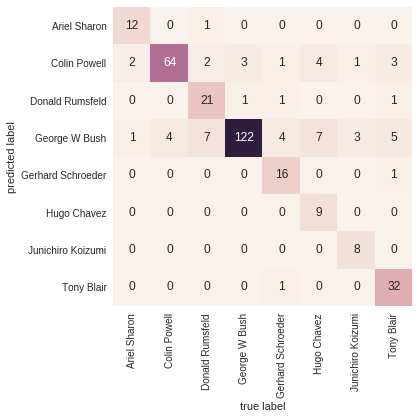

In [18]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');